## Import Libraries

In [28]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

from skimage.transform import resize
from skimage.io import imread

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

import os

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Dataset

In [30]:
dir_path = '../Peliculas_New/'

In [31]:
def get_dataframe(path):
    videos = []
    labels = []
    for folder in os.listdir(path):
        fd = dir_path + folder + '/'
        for video in os.listdir(fd):
            vd = os.path.join(fd, video)
            i = 1 if folder == 'fights' else 0
            videos.append(vd)
            labels.append(i)
    data_dict = {
        'videos': videos,
        'labels': labels 
    }
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

In [32]:
df = get_dataframe(dir_path)
df.head(), df.tail()

(                              videos  labels
 0    Peliculas_New/fights/newfi1.avi       1
 1   Peliculas_New/fights/newfi10.avi       1
 2  Peliculas_New/fights/newfi100.avi       1
 3   Peliculas_New/fights/newfi11.avi       1
 4   Peliculas_New/fights/newfi12.avi       1,
                             videos  labels
 195  Peliculas_New/noFights/95.mpg       0
 196  Peliculas_New/noFights/96.mpg       0
 197  Peliculas_New/noFights/97.mpg       0
 198  Peliculas_New/noFights/98.mpg       0
 199  Peliculas_New/noFights/99.mpg       0)

In [33]:
def capture(filename, timesep, rgb, h, w):
    tmp = []
    frames = np.zeros((timesep, rgb, h, w), dtype=float)
    i=0
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        rval = False
    frm = resize(frame, (h, w, rgb))
    frm = np.expand_dims(frm, axis=0)
    frm = np.moveaxis(frm, -1, 1)
    if(np.max(frm) > 1):
        frm = frm / 255.0
    frames[i][:] = frm
    i += 1
    while i < timesep:
        tmp[:] = frm[:]
        rval, frame = vc.read()
        frm = resize(frame,( h, w, rgb))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = np.expand_dims(frm, axis=0)
        if(np.max(frm) > 1):
            frm = frm / 255.0
        frm = np.moveaxis(frm, -1, 1)
        frames[i-1][:] = frm
        i +=1
    return frames.astype(np.float32)

In [34]:
idx = 0
vid = capture(df.iloc[idx, 0], 1, 3, 160, 160)
frame = vid[0].transpose(1, 2, 0)
print(vid.shape, vid.max(), vid.min())

(40, 3, 160, 160) 1.0 0.0


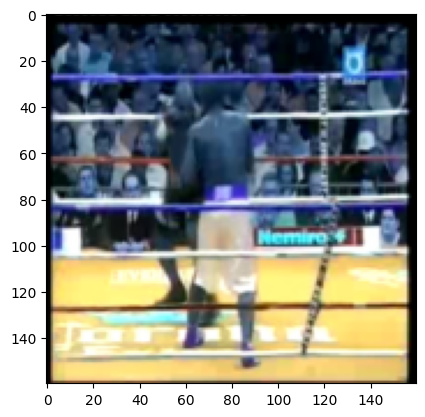

In [35]:
plt.imshow(frame)
plt.show()

In [36]:
from torch.utils.data import Dataset 

class VideoDataset(Dataset):

    def __init__(self, datas, timesep=40, rgb=3, h=160, w=160):
        self.dataloctions = datas
        self.timesep, self.rgb, self.h, self.w = timesep, rgb, h, w

    def __len__(self):
        return len(self.dataloctions)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        video = capture(self.dataloctions.iloc[idx, 0], self.timesep, self.rgb, self.h, self.w)
        sample = {'video': torch.from_numpy(video), 'label': torch.from_numpy(np.asarray(np.float32(self.dataloctions.iloc[idx, 1])))}
        return sample

In [37]:
dataset = VideoDataset(df)
len(dataset)

200

In [38]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [140, 30, 30], generator=torch.Generator().manual_seed(42))
len(train_set), len(val_set), len(test_set)

(140, 30, 30)

In [51]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = 3, shuffle = True)
validloader = torch.utils.data.DataLoader(val_set, batch_size = 3, shuffle = True)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = False)

In [40]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))
print("Total no. batches in trainloader : {}".format(len(testloader)))

Total no. batches in trainloader : 47
Total no. batches in validloader : 10
Total no. batches in trainloader : 10


## Create model

In [41]:
class TimeWarp(nn.Module):
    def __init__(self, baseModel, method='squeeze'):
        super(TimeWarp, self).__init__()
        self.baseModel = baseModel
        self.method = method
 
    def forward(self, x):
        batch_size, time_steps, C, H, W = x.size()
        if self.method == 'loop':
            output = []
            for i in range(time_steps):
                x_t = self.baseModel(x[:, i, :, :, :])
                x_t = x_t.view(x_t.size(0), -1)
                output.append(x_t)
            x = torch.stack(output, dim=0).transpose_(0, 1)
            output = None
            x_t = None
        else:
            x = x.contiguous().view(batch_size * time_steps, C, H, W)
            x = self.baseModel(x)
            x = x.view(x.size(0), -1)
            x = x.contiguous().view(batch_size , time_steps , x.size(-1))
        return x

In [42]:
class extractlastcell(nn.Module):
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]

In [43]:
# Create model
num_features = 12800
rnn_hidden_size = 30
rnn_num_layers = 2
dr_rate= 0.2
num_classes = 1

ResNet50 = models.resnet50(pretrained=True)
custom_RN50 = nn.Sequential()
ct = 0
for child in ResNet50.children():
    if ct < 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = False
    elif ct == 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = True
    else:
        break
    ct += 1
custom_RN50.append(nn.AdaptiveAvgPool2d(output_size=(5, 5)))

model = nn.Sequential(
        TimeWarp(custom_RN50),
        nn.Dropout(dr_rate),
        nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers , batch_first=True),
        extractlastcell(),
        nn.Linear(30, 256),
        nn.ReLU(),
        nn.Dropout(dr_rate),
        nn.Linear(256, num_classes)
    )

c:\Users\CV\miniconda3\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\CV\miniconda3\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.to(device)
model, device

In [45]:
random_img = torch.rand(3, 40, 3, 160, 160).to(device)
model(random_img).shape

torch.Size([3, 1])

In [46]:
class EarlyStopping():
    def __init__(self, tolerance=2, min_delta=0.05):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            print(self.counter)
            if self.counter >= self.tolerance:  
                self.early_stop = True

## Training

In [47]:
def fit(model, trainloader, validloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_valid_loss = np.Inf
    early_stopping = EarlyStopping(tolerance=3, min_delta=0.09)

    train_loss_means, train_acc_means = [], []
    val_loss_means, val_acc_means = [], []
    epoch_arr = []

    for epoch in range(1, epochs+1):
        epoch_arr.append(epoch)
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(trainloader)
        for batch in bar:
            X, y = batch['video'], batch['label']
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).squeeze(1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            mean_tl = np.mean(train_loss)

            y_hat = y_hat > 0.5
            co_num = (y == y_hat)
            acc = co_num.sum().item() / len(y)
            # print(y_hat, y, co_num, acc)

            train_acc.append(acc)
            mean_ta = np.mean(train_acc)
            bar.set_description(f"loss {mean_tl:.5f} acc {mean_ta:.5f}")
        train_loss_means.append(mean_tl)
        train_acc_means.append(mean_ta)

        bar = tqdm(validloader)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch['video'], batch['label']
                X, y = X.to(device), y.to(device)
                y_hat = model(X).squeeze(1)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                mean_vl = np.mean(val_loss)
                
                y_hat = y_hat > 0.5
                co_num = (y == y_hat)
                acc = co_num.sum().item() / len(y)
                # print(y_hat, y, co_num, acc)

                val_acc.append(acc)
                mean_va = np.mean(val_acc)
                bar.set_description(f"val_loss {mean_vl:.5f} val_acc {mean_va:.5f}")
            val_loss_means.append(mean_vl)
            val_acc_means.append(mean_va)

        # best valid loss
        if mean_vl < best_valid_loss:
            torch.save(model.state_dict(), '../weights/best_model.pth')
            print("WEIGHTS-ARE-SAVED")
            best_valid_loss = mean_vl
        # early stopping
        early_stopping(mean_tl, mean_vl)
        if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break
        print(f"Epoch {epoch}/{epochs} loss {mean_tl:.5f} val_loss {mean_vl:.5f} acc {mean_ta:.5f} val_acc {mean_va:.5f}")
    return train_loss_means, train_acc_means, val_loss_means, val_acc_means, epoch_arr

In [21]:
fit_func = fit(model, trainloader, validloader)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 1/10 loss 0.65973 val_loss 0.61731 acc 0.46809 val_acc 0.63333


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 2/10 loss 0.55284 val_loss 0.56079 acc 0.61702 val_acc 0.93333


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 3/10 loss 0.39943 val_loss 0.35689 acc 0.92908 val_acc 1.00000


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 4/10 loss 0.23575 val_loss 0.19787 acc 0.99291 val_acc 0.96667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 5/10 loss 0.11320 val_loss 0.06525 acc 0.98227 val_acc 1.00000


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 6/10 loss 0.04389 val_loss 0.04941 acc 1.00000 val_acc 1.00000


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/10 loss 0.02390 val_loss 0.08347 acc 1.00000 val_acc 0.96667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/10 loss 0.05109 val_loss 0.06426 acc 0.98582 val_acc 1.00000


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/10 loss 0.01372 val_loss 0.05008 acc 1.00000 val_acc 1.00000


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 10/10 loss 0.00932 val_loss 0.01062 acc 1.00000 val_acc 1.00000


## Plotting Results

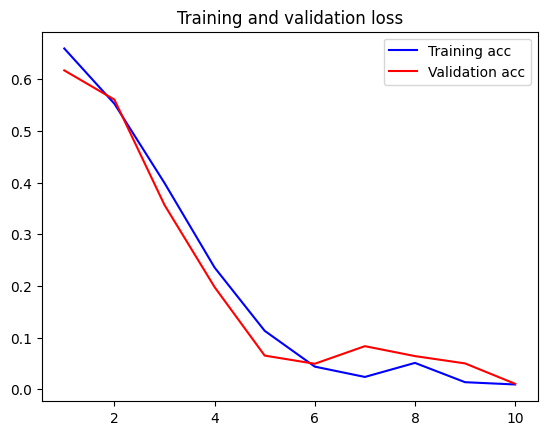

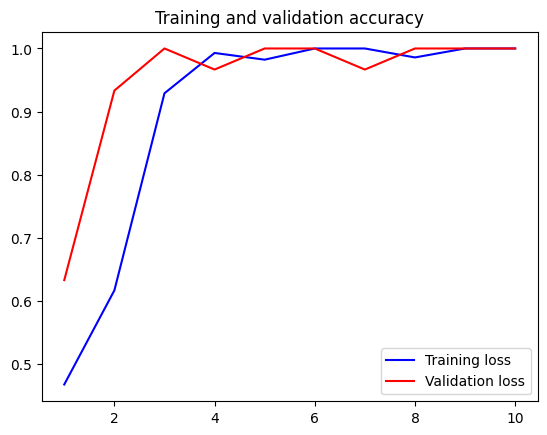

In [23]:
train_loss_means, train_acc_means, val_loss_means, val_acc_means, epochs = fit_func

plt.plot(epochs, train_loss_means, 'b', label='Training acc')
plt.plot(epochs, val_loss_means, 'r', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()
 
plt.figure()

plt.plot(epochs, train_acc_means, 'b', label='Training loss')
plt.plot(epochs, val_acc_means, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

## Predicts

In [52]:
model.eval()
vid_preds, lbs = [], []
with torch.no_grad():
    for batch in testloader:
        vid, lab = batch['video'], batch['label']
        vid, lab = vid.to(device), lab.to(device)
        vid_hat = model(vid).squeeze(1)
        vid_hat = torch.sigmoid(vid_hat)
        vid_preds.append(vid_hat.item())
        lbs.append(int(lab))
        print(f"Valor predicho: {vid_hat.item():.5f} Valor real: {lab.item():.5f}")

Valor predicho: 0.00234 Valor real: 0.00000
Valor predicho: 0.00232 Valor real: 0.00000
Valor predicho: 0.00234 Valor real: 0.00000
Valor predicho: 0.97589 Valor real: 1.00000
Valor predicho: 0.98144 Valor real: 1.00000
Valor predicho: 0.97303 Valor real: 1.00000
Valor predicho: 0.00234 Valor real: 0.00000
Valor predicho: 0.00233 Valor real: 0.00000
Valor predicho: 0.00689 Valor real: 0.00000
Valor predicho: 0.00234 Valor real: 0.00000
Valor predicho: 0.88996 Valor real: 1.00000
Valor predicho: 0.00233 Valor real: 0.00000
Valor predicho: 0.97861 Valor real: 1.00000
Valor predicho: 0.00234 Valor real: 0.00000
Valor predicho: 0.98110 Valor real: 1.00000
Valor predicho: 0.00235 Valor real: 0.00000
Valor predicho: 0.94687 Valor real: 1.00000
Valor predicho: 0.00236 Valor real: 0.00000
Valor predicho: 0.00691 Valor real: 0.00000
Valor predicho: 0.95998 Valor real: 1.00000
Valor predicho: 0.96363 Valor real: 1.00000
Valor predicho: 0.80139 Valor real: 1.00000
Valor predicho: 0.96686 Valor re

In [59]:
threshold = 0.8
preds_lbs = []
for pred in vid_preds:
    if pred > threshold:
        preds_lbs.append(1)
    else:
        preds_lbs.append(0)

<AxesSubplot: >

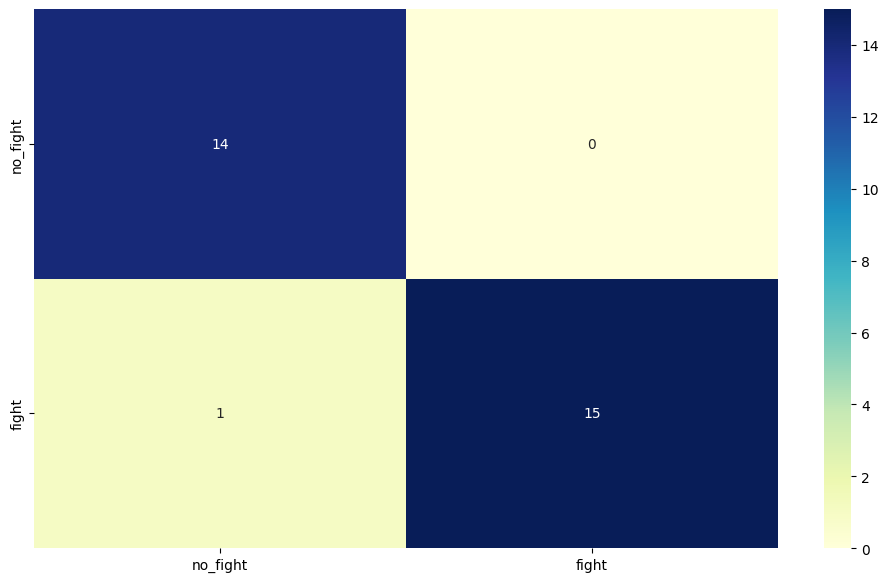

In [62]:
# constant for classes
classes = ('no_fight', 'fight')

# Build confusion matrix
cf_matrix = confusion_matrix(lbs, preds_lbs)
df_cm = pd.DataFrame(cf_matrix,
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap="YlGnBu", annot=True)
# plt.savefig('output.png')

In [63]:
print('Classification Report')
print(classification_report(lbs, preds_lbs, target_names=['no-violance','violance']))

Classification Report
              precision    recall  f1-score   support

 no-violance       0.93      1.00      0.97        14
    violance       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
df = pd.DataFrame(classification_report(lbs, preds_lbs, target_names=['no-violance','violance'], output_dict=True)).transpose()
df